# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Introduction

This post discuss in detail the project "Create a Customer Segmentation Report for Arvato Financial Services", which is one of the Data Scientist's nanodegree capstone options. It is in fact a continuation of a previous project whose solution was posted [here](https://github.com/bvcmartins/dsndProject3). I chose it because of its broad scope which involves a reasonably complex data cleaning procedure, unsupervised learning, analysis of imbalanced data, and prediction using supervised learning tools. In the following I will discuss my solution for it.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor


from imblearn.over_sampling import SMOTE, SMOTENC

from scipy.stats import ks_2samp
import warnings
import ast
import re

import umap
import xgboost
from xgboost import XGBClassifier


from keras.layers import Input, Dense, Activation
from keras.models import Model, Sequential
from keras import regularizers
from keras.layers import Flatten, Dropout
from keras.layers import Conv2DTranspose, Reshape
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD

%matplotlib inline

In [3]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 500
warnings.filterwarnings('ignore')

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Exploratory Data Analysis

In [4]:
azdias = pd.read_csv('data/azdias.csv')
customers = pd.read_csv('data/customers.csv')
azdias.drop('Unnamed: 0', axis=1, inplace=True)
customers.drop('Unnamed: 0', axis=1, inplace=True)

### Azdias: general population dataset 

In [6]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

The dataset has almost 900k entries and 366 features. 

In [7]:
azdias.shape

(891221, 366)

Most of them are numerical and most of them are ordinal. The integer numbers only represent a label for hierachical categories. Columns marked as float are actually comprised by ints but were marked that way only because they contain NaN, which is itself a float. The latest pandas version allows us to use the type Int64 which supports a integer NaN.

In [8]:
azdias.dtypes

LNR                              int64
AGER_TYP                         int64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                  object
CAMEO_DEUG_2015                 object
CAMEO_INTL_2015                 object
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float64
CJT_TYP_2                      float64
CJT_TYP_3                      float64
CJT_TYP_4                

There are also 6 features of type object. These are categorical variables, except for EINGEFUEGT_AM, which is datetime.

In [9]:
azdias.dtypes[azdias.dtypes=='object']

CAMEO_DEU_2015              object
CAMEO_DEUG_2015             object
CAMEO_INTL_2015             object
D19_LETZTER_KAUF_BRANCHE    object
EINGEFUEGT_AM               object
OST_WEST_KZ                 object
dtype: object

Most features contain NaNs which appear in blocks. 

In [12]:
azdias.isnull().values.any()

True

### Customers: current customers dataset

In [13]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

Customers data has three extra columns.

In [14]:
customers.shape

(191652, 369)

These are CUSTOMER_GROUP, ONLINE_PURCHASE, PRODUCT_GROUP

In [15]:
extra_cols = list(set(customers.columns.values).difference(set(azdias.columns.values)))
extra_cols

['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE']

Two of them are objects and the other is int.

In [16]:
customers.dtypes[extra_cols]

CUSTOMER_GROUP     object
PRODUCT_GROUP      object
ONLINE_PURCHASE     int64
dtype: object

The customers dataframe is also full of NaNs.

In [17]:
customers.isnull().values.any()

True

Attributes [-1,0] indicate missing or unknown

In [18]:
dias_attr = pd.read_excel('data/DIAS Attributes - Values 2017.xlsx', skiprows=[0])
dias_attr.drop('Unnamed: 0', axis=1, inplace=True)
dias_attr

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [19]:
dias_info = pd.read_excel('data/DIAS Information Levels - Attributes 2017.xlsx', skiprows=[0])
dias_info.drop('Unnamed: 0', axis=1, inplace=True)
dias_info.replace({'D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24':'D19_GESAMT_ANZ_12-24',
                  'D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24':'D19_BANKEN_ ANZ_12-24',
                 'D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24':'D19_TELKO_ ANZ_12-24',
                 'D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24':'D19_VERSI_ ANZ_12-24',
                 'D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24':'D19_VERSAND_ ANZ_12-24'},inplace=True)
dias_info

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


Note that features 'EINWOHNER', 'PLZ', 'GKZ', 'PLZ8' are not in azdias

## Data Cleaning

Cleaning this dataset was a relatively complex task. The steps are outlined below:

* pre-cleaning
* converting missing values to NaN
* assessing missing data per feature
* assessing missing data per row
* converting mixed-type features to ordinal or binary features
* one-hot encoding categorical features
* standard scaling numerical features

#### Preliminary cleaning - convert  numeric dtypes to Int64, which supports a int NaN. Replace also some of the non-standard missing values codes.

In [20]:
def pre_clean(df):
    list_numeric = df.dtypes[(df.dtypes=='float64') | (df.dtypes=='int64') ].index.values.tolist()
    df[list_numeric] = df[list_numeric].astype('Int64')
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W':0, 'O':1}).astype("Int64")
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace({'XX':np.nan})
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace({'X':np.nan})
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace({'XX':np.nan})
    df['LP_LEBENSPHASE_FEIN'] = df['LP_LEBENSPHASE_FEIN'].replace({0:np.nan}).astype('Int64')
    df['LP_LEBENSPHASE_GROB'] = df['LP_LEBENSPHASE_GROB'].replace({0:np.nan}).astype('Int64')
    return df.drop('EINGEFUEGT_AM', axis=1)

In [21]:
azdias = pre_clean(azdias)

#### Missing Data - convert missing value codes to NaNs


In [22]:
def map_values(x, dict_missing):
    try:
        return dict_missing[x]
    except:
        return x
    
def missing_values(df):
    missing_df = dias_attr.query('Meaning=="unknown"')[['Attribute','Value']].dropna().set_index('Attribute')
    missing_df = missing_df['Value'].astype('str').str.split(',',expand=True).T
    missing_df = missing_df.applymap(lambda x: int(x) if x!=None else -100)

    for i in missing_df.columns.values:
        for j in [0,1]:
            dict_missing = {missing_df.loc[j,i]:np.nan}
            try:
                df[i] = df[i].map(lambda x: map_values(x, dict_missing)).astype('Int64')
            except:
                pass

    return df

In [23]:
%%time
azdias = missing_values(azdias)

CPU times: user 3min 45s, sys: 775 ms, total: 3min 46s
Wall time: 3min 46s


#### Assess missing data per feature

Features with more than 445k, half the total number of entries, were dropped

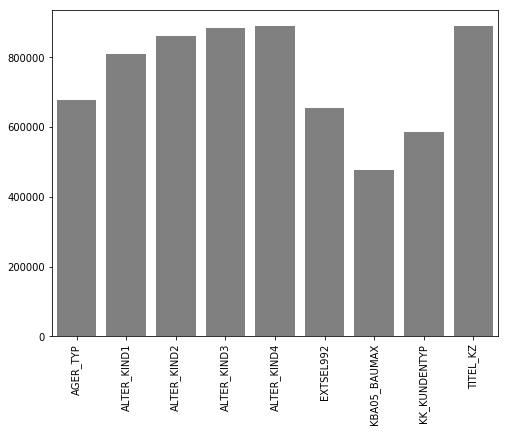

In [24]:
null_df = azdias.isnull().sum()
null_df = null_df[null_df > 445E3]
fig,ax = plt.subplots(figsize=(8,6))
ax = sns.barplot(null_df.index, null_df.values, color='gray')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

Dropping these columns we eliminated 18% of all missing values

In [25]:
azdias[null_df.index].isnull().sum().sum() / azdias.isnull().sum().sum()

0.18222273002095582

In [26]:
feature_drop_list = pd.Series(azdias.isnull().sum()).where(lambda x:  x > 445E3).dropna().index.tolist()
feature_drop_list

['AGER_TYP',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ']

In [27]:
def drop_features(df, feature_drop_list):
    """
    Drops features with too many missing values as listed of feature_drop_list
    """
    return df.drop(feature_drop_list, axis=1)

In [28]:
azdias = drop_features(azdias, feature_drop_list)

### Assess missing data per row

After analyzing missing data per column, we tackled the issue of assessing missing data per row.

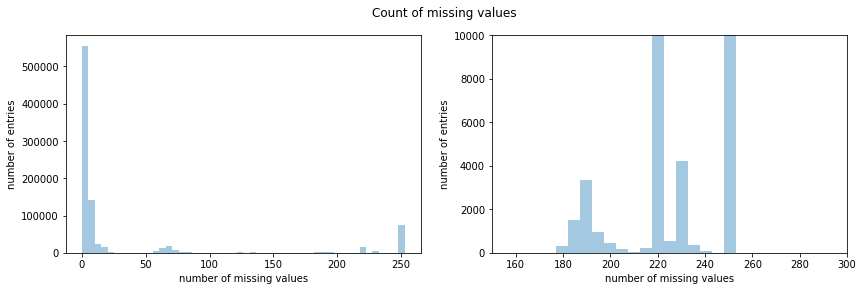

In [30]:
missing_rows = azdias.isnull().sum(axis=1)
fig,ax = plt.subplots(figsize=(14,4), ncols=2, nrows=1)
sns.distplot(missing_rows, kde=False, ax=ax[0])
ax[0].set_xlabel('number of missing values')
ax[0].set_ylabel('number of entries')
sns.distplot(missing_rows, kde=False, ax=ax[1])
ax[1].set_xlim([150,300])
ax[1].set_ylim([0,10000])
ax[1].set_xlabel('number of missing values')
ax[1].set_ylabel('number of entries');
plt.suptitle('Count of missing values');

Cutoff for missing values is 180

In [31]:
azdias_below = azdias[azdias.isnull().sum(axis=1)<180].copy().reset_index().drop('index', axis=1)
azdias_above = azdias[azdias.isnull().sum(axis=1)>=180].copy().reset_index().drop('index', axis=1)

We apply a Kolmogorov-Smirnov test to check if the selected rows are overall different than the main body of data. The null hypothesis is that both groups are identical.

In [34]:
list_numeric = azdias.dtypes[(azdias.dtypes=='int64') | 
                             (azdias.dtypes=='Int64') | 
                             (azdias.dtypes=='float64')].index[1:].tolist()
columns_not_missing = (azdias_above.isnull().sum()==0).index[1:].tolist()
columns_test = set(columns_not_missing).intersection(set(list_numeric))
n_tests = len(columns_test)

In [33]:
ks_df = pd.DataFrame(azdias[columns_test].columns, columns=['col'])
  
def hypothesis_test(df1, df2, cols):
    stats = []
    pvalues = []
    for col in cols:
        counts_main = df1[col].value_counts().sort_index()
        counts_drop = df2[col].value_counts().sort_index()
        try:
            ch = ks_2samp(counts_main, counts_drop)
            stats.append(ch.statistic)
            pvalues.append(ch.pvalue)
        except:
            stats.append(np.nan)
            pvalues.append(np.nan)

    return stats, pvalues

stats, pvalues = hypothesis_test(azdias_below[columns_test], azdias_above[columns_test], azdias_below[columns_test].columns.values)
ks_df['stats'] = stats
ks_df['pvalues'] = pvalues
ks_df.dropna(axis=0, inplace=True)

Because we are executing multiple comparisons, we apply the Bonferroni correction to the pvalues. Only 
The KS test showed that 83% of the columns have a low p-value. This suggests that the groups are not equal. However, note that this conclusion is not based on a formal result which would require a treatment for multiple comparisons.

In [35]:
ks_df[ks_df['pvalues']<0.05/n_tests].shape[0] / ks_df.shape[0]

0.08287292817679558

Text(0.5, 1.0, 'p-value per column for removed data')

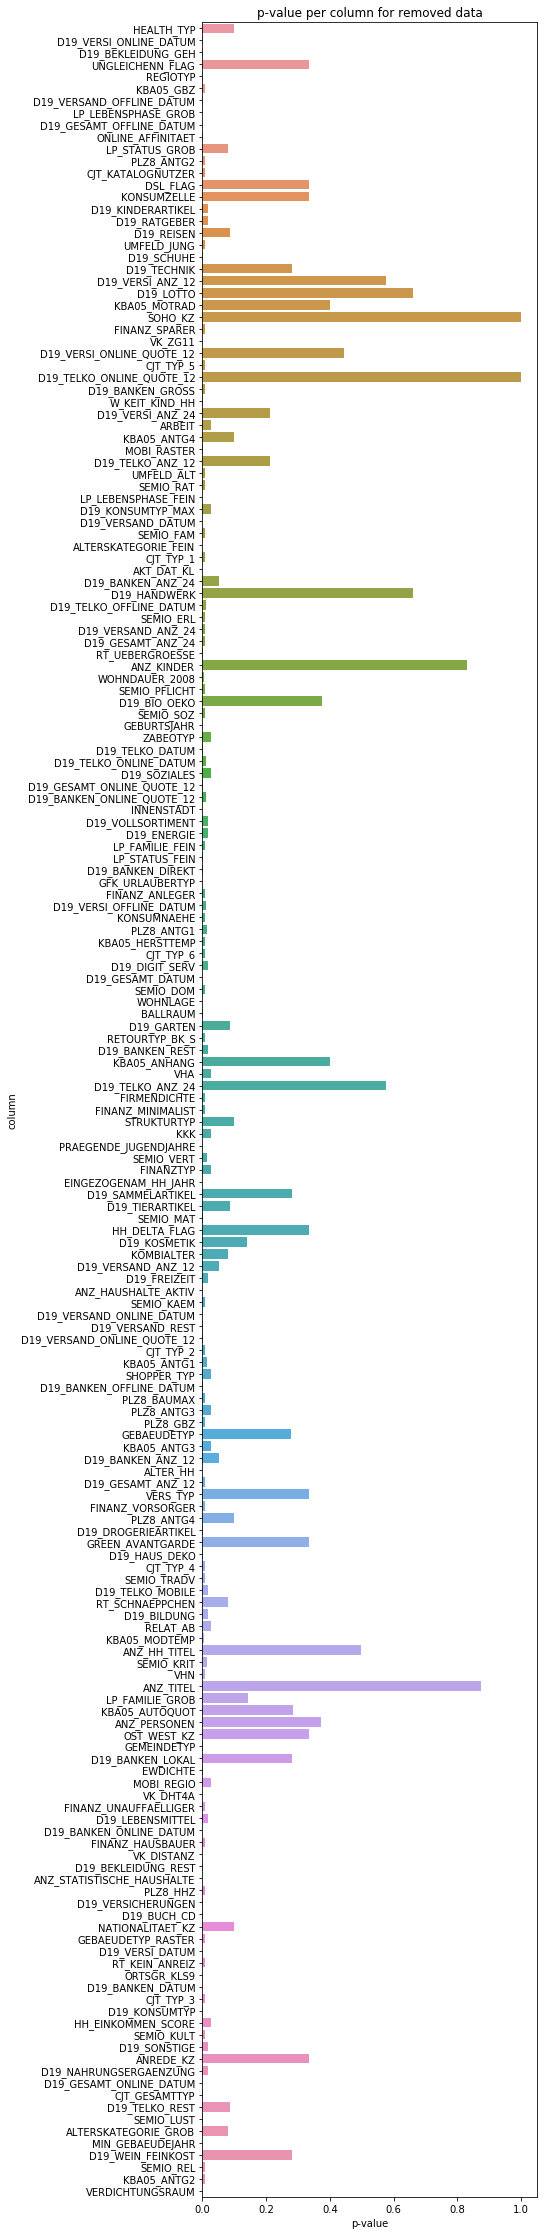

In [36]:
fig,ax = plt.subplots(figsize=(6,40))
sns.barplot(y='col', x='pvalues', data=ks_df, ax=ax)
ax.set_xlabel('p-value')
ax.set_ylabel('column');
ax.set_title('p-value per column for removed data')

We therefore take only azdias_below.

## Data Imputation

#### first update list of numeric and object columns

#### Impute ints using median, floats using mean and objects using most frequent value

In [37]:
#impute_estimator = KNeighborsRegressor(n_neighbors=5)
#impute_estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0)
def impute_numeric(df, strategy):
    #imputer = IterativeImputer(random_state=0, estimator=impute_estimator, verbose=2)
    imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imputer.fit(df)
    return imputer.transform(df)

def impute_object(df):
    list_mode = df.apply(lambda x: x.mode()[0]).values.tolist()
    list_columns = df.columns.values.tolist()
    dict_mode = {i:j for i,j, in zip(list_columns, list_mode)}
    return df.fillna(value=dict_mode)
    
def impute_calc(df):
    list_numeric = df.dtypes[(df.dtypes=='int64') | 
                             (df.dtypes=='Int64') | 
                             (df.dtypes=='float64')].index[1:].tolist()
    df[list_numeric] = impute_numeric(df[list_numeric].astype('Int64'),'median').astype('int64')
    list_objects = df.dtypes[(df.dtypes=='object')].index.tolist()
    df[list_objects] = impute_object(df[list_objects])
    
    return df

In [38]:
azdias = impute_calc(azdias)

In [39]:
azdias.isnull().values.any()

False

### Re-encode mixed features

After cleaning the data of all NaNs, the next step was to re-encode the variables with mixed fetures. The variables were:

* PRAEGENDE_JUGENDJAHRE
* CAMEO_INTL_2015
* LP_LEBENSPHASE_FEIN
* LP_LEBENSPHASE_GROB

Variable  PLZ8_BAUMAX could also have been reencoded but the explanatory gains were not clear. The description of the new variables and their levels is presented on the notebook.

#### PRAEGENDE_JUGENDJAHRE

#### Two new attributes were created 

#### Levels for PRAGENDE_JUGENDJAHRE_intervall  
#### Dictionary pji_dict
- 1: 40s
- 2: 50s
- 3: 60s
- 4: 70s
- 5: 80s
- 6: 90s

#### Levels for PRAGENDE_JUGENDJAHRE_trend
#### Dictionary pjt_dict
- 0: mainstream
- 1: avantgarde

In [40]:
def pragende_jugendjahre(df):
    pji_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    pjt_dict = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    df['PRAEGENDE_JUGENDJAHRE_intervall'] = \
    df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pji_dict[int(x)])
    df['PRAEGENDE_JUGENDJAHRE_trend'] = \
    df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pjt_dict[int(x)])
# drop original attribute from dataset
    return df.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

In [41]:
azdias = pragende_jugendjahre(azdias)

### Mixed-type variable CAMEO_INTL_2015

#### Two new attributes were created

#### Levels for CAMEO_INTL_2015_reichtum
#### Dictionary cir_dict
- 1: Wealthy
- 2: Prosperous
- 3: Comfortable
- 4: Less Affluent
- 5: Poorer

#### Levels for CAMEO_INTL_2015_leben
#### Dictionary cil_dict
- 1: Pre-Family Couples & Singles
- 2: Young Couples With Children
- 3: Families With School Age Children
- 4: Older Families &  Mature Couples
- 5: Elders In Retirement

In [42]:
def cameo_intl_2015(df):
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype('int64')
    cir_dict = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2, 31:3, 32:3, 33:3, 34:3, 
            35:3, 41:4, 42:4, 43:4, 44:4, 45:4, 51:5, 52:5, 53:5, 54:5, 55:5}
    cil_dict = {11:1, 12:2, 13:3, 14:4, 15:5, 21:1, 22:2, 23:3, 24:4, 25:5, 31:1, 32:2, 33:3, 34:4, 
            35:5, 41:1, 42:2, 43:3, 44:4, 45:5, 51:1, 52:2, 53:3, 54:4, 55:5}
    df['CAMEO_INTL_2015_reichtum'] = df['CAMEO_INTL_2015'].map(cir_dict).astype('int64')
    df['CAMEO_INTL_2015_leben'] = df['CAMEO_INTL_2015'].map(cil_dict).astype('int64')
    return df.drop('CAMEO_INTL_2015', axis=1)

In [43]:
azdias = cameo_intl_2015(azdias)

### Mixed-type variable LP_LEBENSPHASE_FEIN

#### Three new attributes were created.

#### Levels for LP_LEBENSPHASE_FEIN_alter
#### Dictionary llfa_dict

- 1: young age
- 2: middle age
- 3: retirement age
- 4: advanced age
- 5: higher age

#### Levels for LP_LEBENSPHASE_FEIN_verdiener
#### Dictionary llfv_dict

- 1: low-income earners 
- 2: average earner
- 3: independent
- 4: homeowner
- 5: top earner
- 6: wealthy

#### Levels for LP_LEBENSPHASE_FEIN_familie
#### Dictionary llff_dict

- 1: single
- 2: single parent
- 3: multiperson households
- 4: families
- 5: couples

In [44]:
def lp_lebensphase_fein(df):
    df['LP_LEBENSPHASE_FEIN'] = df['LP_LEBENSPHASE_FEIN'].astype('int64')
    llfa_dict={1:1, 2:2, 3:1, 4:2, 5:4, 6:3, 7:4, 8:3, 9:2, 10:6, 11:4, 12:3, 13:5, 14:1, 15:5, 
           16:5, 17:2, 18:1, 19:5, 20:5, 21:2, 22:2, 23:2, 24:2, 25:2, 26:2, 27:2, 28:2, 29:1, 30:1, 
           31:5, 32:5, 33:1, 34:1, 35:1, 36:5, 37:4, 38:3, 39:2, 40:3}

    llfv_dict={1:1, 2:1, 3:2, 4:2, 5:1, 6:1, 7:2, 8:2, 9:3, 10:3, 11:4, 12:4, 13:5, 14:2, 15:1, 
           16:2, 17:3, 18:6, 19:4, 20:5, 21:1, 22:2, 23:5, 24:1, 25:2, 26:3, 27:4, 28:5, 29:1, 30:2, 
           31:1, 32:2, 33:3, 34:4, 35:5, 36:3, 37:4, 38:4, 39:5, 40:5}

    llff_dict={1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:5, 15:5, 
           16:5, 17:5, 18:5, 19:5, 20:5, 21:2, 22:2, 23:2, 24:4, 25:4, 26:4, 27:4, 28:4, 29:3, 30:3, 
           31:3, 32:3, 33:3, 34:3, 35:3, 36:3, 37:3, 38:3, 39:3, 40:3}

    # transformation of LP_LEBENSPHASE_FEIN
    df['LP_LEBENSPHASE_FEIN_alter'] = df['LP_LEBENSPHASE_FEIN'].map(llfa_dict).astype('int64')
    df['LP_LEBENSPHASE_FEIN_verdiener'] = df['LP_LEBENSPHASE_FEIN'].map(llfv_dict).astype('int64')
    df['LP_LEBENSPHASE_FEIN_familie'] = df['LP_LEBENSPHASE_FEIN'].map(llff_dict).astype('int64')
    # drop original attribute from dataset
    return df.drop('LP_LEBENSPHASE_FEIN', axis=1)



In [45]:
azdias = lp_lebensphase_fein(azdias)

### Mixed-type variable LP_LEBENSPHASE_GROB

#### Three new attributes were created

#### Levels for LP_LEBENSPHASE_GROB_alter:
#### Dictionary llga_dict  
- 1: young age  
- 2: middle age  
- 3: higher age  

#### Levels for LP_LEBENSPHASE_GROB_verdiener:
#### Dictionary llgv_dict  
- 0: low-income and average earner  
- 1: high-income  

#### Levels for LP_LEBENSPHASE_GROB_familie:
#### Dictionary llgf_dict  
- 1: single
- 2: couples
- 3: families
- 4: multiperson
- 5: single parents

In [46]:
def lp_lebensphase_grob(df):
    df['LP_LEBENSPHASE_GROB'] = df['LP_LEBENSPHASE_GROB'].astype('int64')
    llga_dict={1:1, 2:3, 3:2, 4:2, 5:2, 6:2, 7:2, 8:2, 9:1, 10:3, 11:1, 12:3}
    llgv_dict={1:0, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:0, 11:1, 12:1}
    llgf_dict={1:1, 2:1, 3:1, 4:2, 5:2, 6:5, 7:3, 8:3, 9:4, 10:4, 11:4, 12:4}
    
    df['LP_LEBENSPHASE_GROB_alter'] = df['LP_LEBENSPHASE_GROB'].map(llga_dict).astype('int64')
    df['LP_LEBENSPHASE_GROB_verdiener'] = df['LP_LEBENSPHASE_GROB'].map(llgv_dict).astype('int64')
    df['LP_LEBENSPHASE_GROB_familie'] = df['LP_LEBENSPHASE_GROB'].map(llgf_dict).astype('int64')
    # drop original attribute from dataset
    return df.drop('LP_LEBENSPHASE_GROB', axis=1)

In [47]:
azdias = lp_lebensphase_grob(azdias)

### One-hot encoding

The data was cleaned and variables were reencoded. Next we performed one-hot encoding with cardinal variables, the few ones that were encoded as objects or whose integer-encoded levels were not ranked. We also left out binary variables. 

The following variables were one-hot encoded:

* ZABEOTYP
* VERS_TYP
* REGIOTYP
* GFK_URLAUBERTYP
* CJT_GESAMTTYP
* SHOPPER_TYP
* FINANZTYP
* D19_KONSUMTYP
* HEALTH_TYP
* GEBAEUDETYP
* D19_LETZTER_KAUF_BRANCHE
* CAMEO_DEUG_2015
* CAMEO_DEU_201

In [48]:
def make_lists(df):
    list_all = df.columns.tolist()[1:]
    list_onehot = dias_info['Attribute'].str.extract(r'([0-9A-Z_]*TYP)', expand=True).\
    dropna().\
    stack().\
    values.\
    tolist()
    list_onehot = list(set(list_onehot).intersection(set(list_all)))
    list_binary = [column for column in df.columns.tolist() if df[column].value_counts().shape[0]==2]
    #list_onehot = set(list_onehot).difference(set(list_binary))
    list_scale = list(set(list_all).difference(set(list_binary)).difference(set(list_onehot)))
    
    # specific corrections
    list_scale.remove('D19_LETZTER_KAUF_BRANCHE')
    list_onehot.append('D19_LETZTER_KAUF_BRANCHE')
    list_scale.remove('CAMEO_DEUG_2015')
    list_onehot.append('CAMEO_DEUG_2015')
    list_scale.remove('CAMEO_DEU_2015')
    list_onehot.append('CAMEO_DEU_2015')
    
    return list_onehot, list_binary, list_scale

In [49]:
list_onehot, list_binary, list_scale = make_lists(azdias)

In [51]:
def adjust_types(df):
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('int')
    return df.drop('LNR', axis=1)

In [52]:
azdias = adjust_types(azdias)

In [53]:
onehot = OneHotEncoder()
onehot.fit(azdias[list_onehot])
df_onehot = pd.DataFrame(data = onehot.transform(azdias[list_onehot]).todense(), 
                         columns=onehot.get_feature_names())

In [57]:
azdias_mod = pd.concat([azdias.drop(list_onehot, axis=1), df_onehot], axis=1)

### Scaling

At first Standard Scaler was used but it is too sensitive to outliers. A combination of Outlier Removal and Robust Scaling led to better results.

In [86]:
scaler = RobustScaler()
azdias_mod[list_scale] = scaler.fit_transform(azdias_mod[list_scale])

### Removing Outliers

Some of the features had outliers that were skewing the scaling that comes next. Outlier removal was needed at this step to avoid problems with the PCA step. I did some tests with this method in another notebook but it is hard to be absolutely sure that is doing the right thing with such a large dataset.

In [87]:
def remove_outliers(df):
    clf_if = IsolationForest(max_samples=100, random_state=34)
    outlier_pred = clf_if.fit_predict(df)
    outlier_list = np.where(outlier_pred==-1)[0]
    return df.drop(outlier_list, axis=0)

In [88]:
azdias_mod2 = remove_outliers(azdias_mod)

In [90]:
azdias_mod2.shape, azdias_mod.shape

((802099, 496), (891221, 496))

Final result of scaling and outlier removal.

In [ ]:
clf_if = IsolationForest(n_estimators=500, random_state=34)
outlier_pred = clf_if.fit_predict(azdias_mod)

In [104]:
outlier_list = np.where(outlier_pred==-1)[0]

In [107]:
outlier_list

array([     9,     44,     45, ..., 891196, 891213, 891219])

In [98]:
azdias_mod.ANZ_HAUSHALTE_AKTIV.argmax()

209667

In [97]:
azdias_mod2.loc[209667,'ANZ_HAUSHALTE_AKTIV']

84.42857142857144

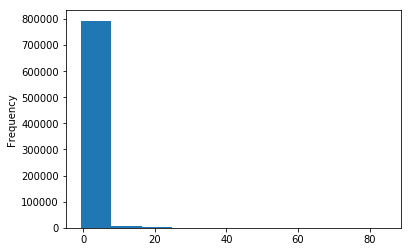

In [94]:
azdias_mod2.ANZ_HAUSHALTE_AKTIV.plot.hist()

In [89]:
azdias_mod2.describe()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINI

### Customer Segmentation Report

The first part of this project analyzed a dataset comprising a sample of the general population of Germany. This dataset will serve as the basis for the prediction analysis that will be carried out below. The analysis comprised the following steps:

1. Reduce dimensionality of the general population dataset
2. Clusterize the reduced space in order to identify customer segments
3. Apply the PCA transformation defined in 1 to the customers dataset
4. Clusterize the customer reduced space and identify which cluster have a population excess

### PCA



In [92]:
def pca_components(df, minRange, maxRange):
    """
    Iterates through PCA dimensions and generates models
    """
    evr = {}
    for i in range(minRange, maxRange):
        
        pca_model = PCA(n_components=i)
        X_pca = pca_model.fit_transform(df)
        evr[i] = pca_model.explained_variance_ratio_.sum()
    return evr

def generate_pca(df, n_components):
    '''
    Generates PCA model
    
    INPUT: df - scaled dataframe
           n_components - number of components for the model
           
    OUTPUT: pca_model - PCA object
            var_pca - dataframe with components and explained variances
            X_pca - numpy array with transformed data
    '''
    pca_model = PCA(n_components)
    X_pca = pca_model.fit_transform(df)
    components = pd.DataFrame(np.round(pca_model.components_, 4), columns = df.keys())
    ratios = pca_model.explained_variance_ratio_.reshape(len(pca_model.components_),1)
    dimensions = ['Dim {}'.format(i) for i in range(len(pca_model.components_))]
    components.index = dimensions
    variance_ratios = pd.DataFrame(np.round(ratios,4), columns=['Explained_Variance'])
    variance_ratios.index = dimensions
    var_pca = pd.concat([variance_ratios, components], axis=1)
    
    return pca_model, var_pca, X_pca

def scree_plot_pca(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantiating of PCA in scikit learn
            
    OUTPUT: None
    '''
    
    num_comp = len(pca.explained_variance_ratio_)
    idx = np.arange(num_comp)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(16,6))
    ax = plt.subplot(111)
    ax.bar(idx, vals*10)
    ax.plot(idx, np.cumsum(vals),'r--')
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained")
    
    plt.title("Explained Variance per Principal Component")

In [93]:
evr = pca_components(azdias_mod2, 120, 130)

KeyboardInterrupt: 

In [ ]:
evr

We chose 124 components because it is the smallest number of components for 80% explained variance ratio.

In [401]:
n_dim = [key for key, value in evr.items() if value>=0.9][0]
n_dim

IndexError: list index out of range

In [410]:
n_dim = 170
list_pca = azdias3.columns.values.tolist()
pca_model, var_pca, X_pca = generate_pca(azdias3, n_dim)

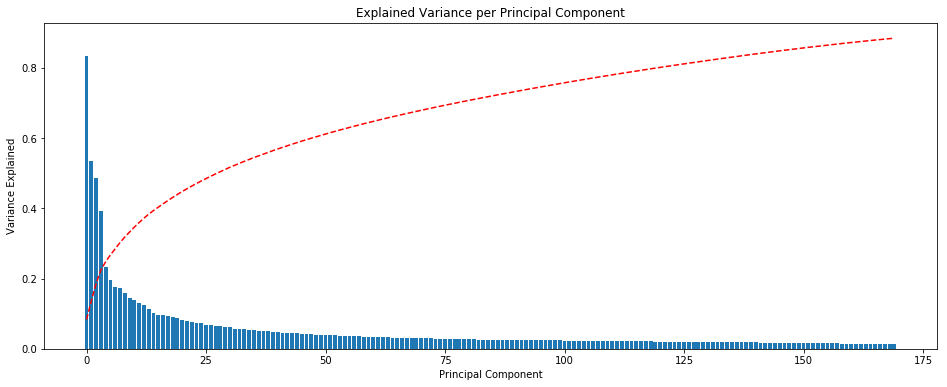

In [411]:
scree_plot_pca(pca_model)

### K-Means

K-Means was used for clustering. DBSCAN was also tried. 

In [189]:
def dist_centroid(X_pca, k_model):
    '''
    Calculates the average distance between points in a certain cluster
    and the cluster centroid.
    
    INPUT: X_pca - transformed PCA dimension
           k_model - instantiated k-means model
           
    OUTPUT: scalar mean distance
    '''
    dist = []
    for i, c in enumerate(k_model.cluster_centers_):
        a = np.array([np.sqrt(np.dot((x - c),(x - c))) for x in X_pca[k_model.labels_ == i]])
        #print(a.shape)
        #print(a.sum())
        #print((k_model.labels_==i).sum())
        dist.append(a.sum() / (k_model.labels_ == i).sum())
    
    return np.array(dist).mean()

def scree_plot_kmeans(X_pca):
    '''
    Generates scree plot for k-means model
    with 1 to 20 components
    
    INPUT: X_pca - numpy array with transformed data
           
    OUTPUT: scalar mean distance
    '''
    
    k_score = []
    k_dist = []
    k_step = []
    for k in range(5,25):
        k_model = KMeans(n_clusters = k, random_state=34).fit(X_pca)
        a = k_model.score(X_pca)
        k_score.append(a)
        b = dist_centroid(X_pca, k_model)
        print('clusters: {}, score: {}, dist: {}'.format(k, a, b))
        k_dist.append(b)
        k_step.append(k)
    return k_step, k_dist, k_score

In [190]:
#k_step, k_dist, k_score = scree_plot_kmeans(X_pca)

In [191]:
#fig, ax = plt.subplots(1,2, figsize=(14,6))
#ax[0].scatter(k_step, k_dist)
#ax[0].set_xlabel('Number of clusters')
#ax[0].set_ylabel('Distance from cluster centroid')
#ax[0].set_xticks(np.arange(0, 25, 1.0));
#ax[1].scatter(k_step, k_score)
#ax[1].set_xlabel('Number of clusters')
#ax[1].set_ylabel('KMeans score')
#ax[1].set_xticks(np.arange(0, 25, 1.0));
#plt.suptitle('Scree plot for K-Means')

In [192]:
def calc_clusters(method):
    model= method.fit(X_pca)
    df = pd.DataFrame(X_pca)
    df['clusters'] = model.labels_
    
    return df, model

def plot_clusters(df):
    palette = sns.color_palette("Set2",11).as_hex()
    colors = []
    colors.extend([palette[10], palette[9], palette[8], palette[7], palette[6]])

    fig, axis = plt.subplots(1, figsize=(8,6))

    sns.scatterplot(x=0, y=1, data=df, ax=axis, hue='clusters')

def plot_pops(df):
    df_ = df.groupby('clusters').agg({'clusters':'size'}).rename(columns={'clusters':'size'}).reset_index()
    sns.barplot(x = 'clusters', y = 'size', data=df_, color='gray')    


In [426]:
n_clusters = 20
kmeans_df, kmeans =  calc_clusters(KMeans(n_clusters = n_clusters, random_state=34))

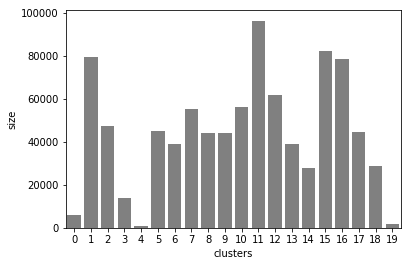

In [427]:
plot_pops(kmeans_df)

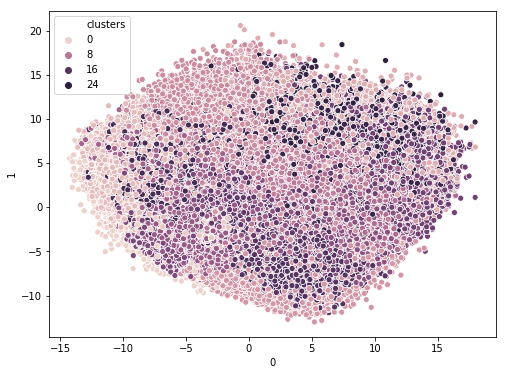

In [428]:
plot_clusters(kmeans_df)

### Apply data processing to customers

In [415]:
def clean_customer(df):
    df_extra = df[['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE']]
    return df.drop(['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE'], axis=1), df_extra

def pipeline(df):
    df = pre_clean(df)
    df = missing_values(df)
    df = drop_features(df, feature_drop_list)
    #df = drop_rows(df)
    df = impute_calc(df)
    df = pragende_jugendjahre(df)
    df = cameo_intl_2015(df)
    df = lp_lebensphase_fein(df)
    df = lp_lebensphase_grob(df)
    df = adjust_types(df)
    #df, df_extra = clean_customer(df)
    df_onehot = pd.DataFrame(data = onehot.transform(df[list_onehot]).todense(), 
                         columns=onehot.get_feature_names())
    df = pd.concat([df.drop(list_onehot, axis=1), df_onehot], axis=1)
    df[list_scale] = scaler.transform(df[list_scale])
    X_pca = pca_model.transform(df[list_pca])
    kmeans_pipe = pd.DataFrame(X_pca)
    kmeans_pipe['clusters'] = kmeans.predict(X_pca)
    
    return df, kmeans_pipe

In [429]:
customers_mod = customers.drop(['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE'],axis=1)

In [430]:
df_customers, kmeans_customers = pipeline(customers_mod.copy())

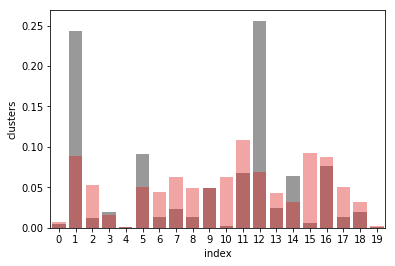

In [431]:
df_agg = kmeans_customers['clusters'].value_counts(normalize=True).reset_index()
df_agg_azdias = kmeans_df['clusters'].value_counts(normalize=True).reset_index()
sns.barplot(x = 'index', y = 'clusters', data=df_agg, color='black', alpha=0.4)
sns.barplot(x = 'index', y = 'clusters', data=df_agg_azdias, color='red', alpha=0.4)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [432]:
mailout_train = pd.read_csv('data/mailout_train.csv')

In [433]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [434]:
mailout_train.shape

(42962, 367)

In [435]:
mailout_train.RESPONSE.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [436]:
df_mailout_train, kmeans_train = pipeline(mailout_train.copy())

In [437]:
df_mailout_train.shape, kmeans_train.shape

((42962, 497), (42962, 171))

In [438]:
kmeans_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,clusters
0,-5.242526,-2.819790,3.466606,7.987966,-0.355161,3.594103,-1.863343,-1.364188,-0.580001,0.109782,0.548363,1.188992,-0.205376,0.080161,-1.193674,-2.296617,1.103262,1.745833,0.456128,-2.196950,-2.055664,-0.968294,0.205799,0.279992,0.428210,0.294552,-1.664451,-1.360105,-0.552156,0.796462,2.969157,-1.546459,1.485974,2.457539,-1.325505,-3.328576,1.446163,-0.957288,-1.761576,1.706292,0.744966,-0.584028,-0.259199,0.336103,0.898804,1.123485,0.502788,-0.031349,0.260607,0.741930,0.944758,-1.441556,0.925714,-1.385007,-1.267335,-0.190205,-1.000659,0.068406,0.869390,0.142402,-1.141762,-0.293481,0.103402,0.124357,-0.410158,-1.902166,-0.490175,-1.092989,0.890093,0.644690,0.314548,-0.734497,-0.268087,-0.577153,-1.022168,0.479473,1.522284,0.519921,-0.238351,0.813204,-0.116695,0.456687,0.280402,-0.000535,0.283956,-0.156036,0.668984,0.444682,0.540334,0.868369,-1.049794,-0.071929,0.380593,0.565426,-1.209105,-1.890394,0.885097,-0.926256,-0.479228,0.937575,1.025425,-0.431886,0.057551,0.341574,-0.084090,-1.038053,0.137636,-1.082088,-1.870703,-0.552433,-1.167840,-0.599334,-0.488262,1.206356,-0.568867,-0.115006,0.641006,-1.782025,-0.396480,0.582517,-0.181990,-0.314206,-0.986593,-1.138414,0.273292,0.362460,-0.002118,1.710079,0.069316,0.401613,0.515482,-1.079335,-0.771414,0.519534,0.453462,1.181408,0.542025,-0.143342,-1.821194,0.654540,-0.079188,-1.521992,-0.050224,-0.691521,0.597670,-0.290514,-2.036453,1.965049,-1.759988,-0.737864,-0.378739,0.300684,-0.160210,0.855339,0.924424,0.979513,0.085441,0.101716,0.539539,0.710825,-0.044330,1.104615,0.195718,0.471484,0.292319,-0.150885,-0.255185,1.118357,-0.025907,-0.271822,11
1,10.322893,0.246382,-3.462087,1.243291,-2.315491,2.583005,-1.556452,-3.385666,0.794743,-0.848353,-0.495269,0.970606,0.074745,-2.157325,0.942408,4.162109,1.266369,0.708861,1.757427,-0.462152,-1.060166,-0.663530,3.597687,0.057835,7.231539,3.647522,-1.979529,2.690052,1.365245,3.962542,-0.656262,-2.216849,-1.271937,-0.446734,1.374544,3.140087,-3.397520,-0.348143,-1.882200,0.699588,-2.434656,-4.560763,0.825547,1.488046,0.449205,-1.105348,-0.275672,-0.414314,-0.722495,1.597347,0.566341,1.380338,-0.518951,-2.077009,0.546876,1.540984,-0.716052,0.306414,0.278718,3.121213,0.021832,-1.653444,0.014519,0.445333,-0.666524,-0.378717,2.431130,0.370548,-0.057348,0.930868,0.424168,-0.737516,0.634830,-0.612142,-0.705352,-1.042795,-0.700915,1.416538,2.026919,1.010319,0.213178,-0.416268,1.269642,-1.157886,0.386593,-4.949941,0.974494,1.323305,-0.283486,1.633832,1.012674,0.035625,0.174462,1.088939,0.677568,-1.031706,-1.431964,-3.019054,4.159017,1.560299,-2.216964,1.506619,-1.335939,0.067977,-0.498764,-0.892501,-1.446369,-0.709228,1.073584,-1.543618,-2.299877,0.212345,0.187903,0.062393,1.413895,0.662083,-2.084333,0.135728,1.358536,2.280799,-1.020103,0.435973,-2.049781,-0.511682,1.401277,0.958908,-0.473499,-0.911034,1.201026,-1.382589,0.358486,0.577770,-0.023291,0.370838,0.191664,0.059542,-2.248358,0.344670,-0.993876,1.182041,0.741706,-1.997416,-0.336165,0.304176,1.094176,-0.285789,0.682052,0.076775,-0.232139,1.885790,-1.130377,-0.399954,0.771648,2.135803,0.225607,0.374484,1.504600,0.452678,1.373265,3.990386,-1.585532,-0.323200,1.418013,-0.461696,-0.464402,0.870804,0.939567,1.251628,0.980230,-1.268633,3
2,3.383135,-3.045356,-2.525831,6.949089,5.223297,0.333759,3.386712,1.282562,-2.266095,3.656656,-3.146627,-0.345642,0.918642,1.123749,-2.460035,0.618398,-1.955109,-1.577929,-0.641023,-3.174871,1

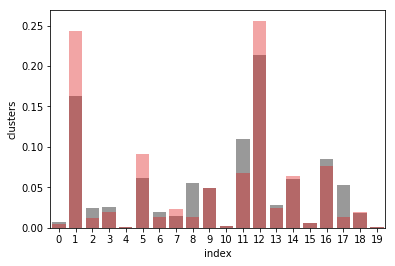

In [439]:
df_mailout_train['clusters'] = kmeans_train['clusters']
df_0 = df_mailout_train.query('RESPONSE==0')['clusters'].value_counts(normalize=True).reset_index()
sns.barplot(x = 'index', y = 'clusters', data=df_0, color='black', alpha=0.4)
sns.barplot(x = 'index', y = 'clusters', data=df_agg, color='red', alpha=0.4)

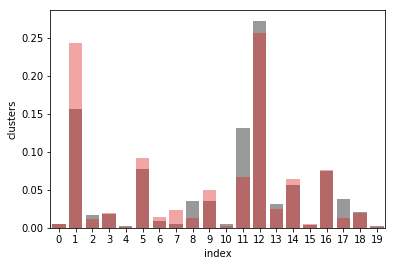

In [440]:
df_1 = df_mailout_train.query('RESPONSE==1')['clusters'].value_counts(normalize=True).reset_index()
sns.barplot(x = 'index', y = 'clusters', data=df_1, color='black', alpha=0.4)
sns.barplot(x = 'index', y = 'clusters', data=df_agg, color='red', alpha=0.4)

In [441]:
kmeans_train['RESPONSE'] = df_mailout_train['RESPONSE']

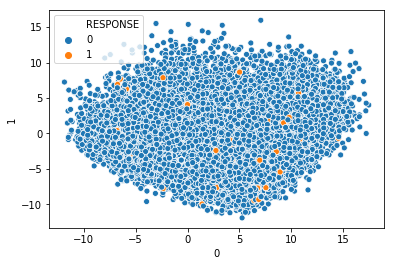

In [454]:
sns.scatterplot(x=0, y=1, data=kmeans_train, hue='RESPONSE')

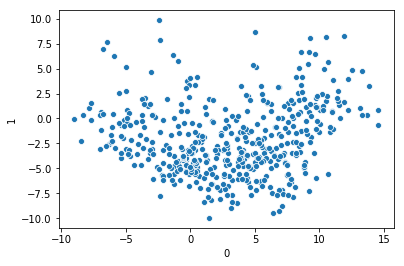

In [467]:
sns.scatterplot(x=0, y=1, data=kmeans_train[kmeans_train.RESPONSE==1])

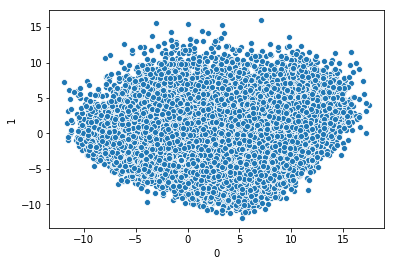

In [468]:
sns.scatterplot(x=0, y=1, data=kmeans_train[kmeans_train.RESPONSE==0])

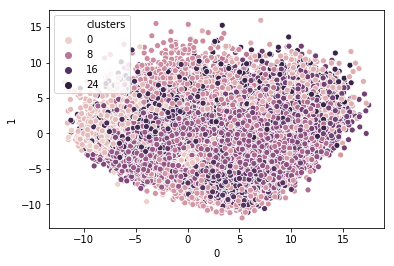

In [469]:
sns.scatterplot(x=0, y=1, data=kmeans_train, hue='clusters')

In [470]:
dummies = pd.get_dummies(kmeans_train.clusters, prefix='cluster')
kmeans_train_extended = pd.concat([kmeans_train.iloc[:,:-2],dummies], axis=1)

In [471]:
y = kmeans_train.RESPONSE
X = kmeans_train_extended

In [472]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=34)

In [473]:
X_train2 = X_train.reset_index(drop=True)
y_train2 = y_train.reset_index(drop=True)
X_test2 = X_test.reset_index(drop=True)
y_test2 = y_test.reset_index(drop=True)

In [532]:
# training the model
clf_if = IsolationForest(max_samples=100, random_state=34)
clf_if.fit(X_train2)

# predictions
y_pred_train = clf_if.predict(X_train2)
y_pred_test = clf_if.predict(X_test2)

In [535]:
outliers_train = np.where(y_pred_train==-1)

(array([   22,    27,    39, ..., 28776, 28779, 28782]),)

In [481]:
y.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [482]:
42430/532

79.75563909774436

In [485]:
def skf_noSMOTE(X, y, model): 

    labels = []
    preds = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=34)
    for train_indices, test_indices in skf.split(X, y):
    
        X_train_skf = X.iloc[train_indices,:]
        y_train_skf = y[train_indices]
    
        X_test_skf = X.iloc[test_indices,:]
        y_test_skf = y[test_indices]
        
        model.fit(X_train_skf, y_train_skf)            
        labels.extend(y_test_skf)
        preds.extend(model.predict(X_test_skf))
    
    print('accuracy :', accuracy_score(labels, preds)) 
    print('F1 :',f1_score(labels, preds))
    print('precision :', precision_score(labels, preds))
    print('recall :', recall_score(labels, preds))
    print('auc :', roc_auc_score(labels, preds))
    display(confusion_matrix(labels, preds))
    
    return model

In [476]:
model1 = AdaBoostClassifier(random_state=34)
model1 = skf_noSMOTE(X_train2, y_train2, model1)

accuracy : 0.9867634797109506
F1 : 0.0
precision : 0.0
recall : 0.0
auc : 0.4998416162184992


array([[28403,     9],
       [  372,     0]])

In [477]:
model2 = RandomForestClassifier(random_state=34)
model2 = skf_noSMOTE(X_train2, y_train2, model2)

accuracy : 0.9869719288493608
F1 : 0.0
precision : 0.0
recall : 0.0
auc : 0.4999472054061664


array([[28409,     3],
       [  372,     0]])

In [486]:
model3 = XGBClassifier(random_state=34, scale_pos_weight=80)
model3 = skf_noSMOTE(X_train2, y_train2, model3)

accuracy : 0.8533560311284046
F1 : 0.030323914541695387
precision : 0.016578749058025623
recall : 0.1774193548387097
auc : 0.519812732466518


array([[24497,  3915],
       [  306,    66]])

In [493]:
model3b = XGBClassifier( learning_rate = 0.05, 
                        n_estimators = 1000, 
                        n_jobs=-1, 
                        random_state=34, 
                        sample_pos_weight=80)
model3b = skf_noSMOTE(X_train2, y_train2, model3b)

accuracy : 0.9870761534185659
F1 : 0.0
precision : 0.0
recall : 0.0
auc : 0.5


array([[28412,     0],
       [  372,     0]])

In [496]:
model3c = XGBClassifier( learning_rate = 0.05, 
                        n_estimators = 1000, 
                        n_jobs=-1, 
                        random_state=34)
model3c = skf_SMOTE(X_train2, y_train2, model3c)

accuracy : 0.9463518935660988
F1 : 0.9453673835125448
precision : 0.9630403826493354
recall : 0.9283313388708996
auc : 0.9463518935660988


array([[109599,   4049],
       [  8145, 105503]])

In [516]:
model3d = XGBClassifier(random_state=34, max_depth=4, scale_pos_weight=80)
model3d = skf_noSMOTE(X_train2, y_train2, model3d)
pred_model(model3d, X_test2, y_test2)

accuracy : 0.9007087270705948
F1 : 0.025903203817314247
precision : 0.01483216237314598
recall : 0.10215053763440861
auc : 0.5066574172052093


array([[25888,  2524],
       [  334,    38]])

accuracy : 0.9341232896036112
F1 : 0.03909465020576131
precision : 0.023399014778325122
recall : 0.11875
auc : 0.5310899379369382
auc : 0.579773773006135


array([[13225,   793],
       [  141,    19]])

In [530]:
Xt = df_mailout_train.iloc[:,:-1]
Xt.drop('RESPONSE', axis=1, inplace=True)
yt = kmeans_train.RESPONSE
X_traint, X_testt, y_traint, y_testt = train_test_split(Xt, yt, test_size=0.33, shuffle=True, random_state=34)
model3e = XGBClassifier(random_state=34, max_depth=4, scale_pos_weight=80)
model3e = skf_noSMOTE(X_traint, y_traint.values, model3e)
pred_model(model3e, X_testt, y_testt)

accuracy : 0.7795997776542524
F1 : 0.041112454655380895
precision : 0.021780909673286355
recall : 0.3655913978494624
auc : 0.575305905879539


array([[22304,  6108],
       [  236,   136]])

accuracy : 0.7484835660883058
F1 : 0.037776578521316787
precision : 0.019740552735476594
recall : 0.4375
auc : 0.5947665501498074
auc : 0.7131870630617777


array([[10542,  3476],
       [   90,    70]])

In [544]:
# training the model
clf_if = IsolationForest(max_samples=100, random_state=34)
clf_if.fit(Xt)

# predictions
outlier_pred = clf_if.predict(Xt)
outlier_pred.shape

(42962,)

In [547]:
outlier_list = np.where(outlier_pred==-1)
outlier_list = [i for i in outlier_list]

In [549]:
outlier_list[0]

array([    5,    21,    34, ..., 42952, 42957, 42960])

In [552]:
Xt2 = Xt.drop(outlier_list[0])
yt2 = yt.drop(outlier_list[0])

In [551]:
Xt2.shape, Xt.shape

((38665, 496), (42962, 496))

In [555]:
X_traint, X_testt, y_traint, y_testt = train_test_split(Xt2, yt2, test_size=0.33, shuffle=True, random_state=34)
model3e = XGBClassifier(random_state=34, max_depth=4, scale_pos_weight=80)
model3e = skf_noSMOTE(X_traint, y_traint.values, model3e)
pred_model(model3e, X_testt, y_testt)

accuracy : 0.8849642926076047
F1 : 0.05276541640178003
precision : 0.029390934844192633
recall : 0.2577639751552795
auc : 0.575311257014375


array([[22842,  2741],
       [  239,    83]])

accuracy : 0.9066614420062696
F1 : 0.06294256490952006
precision : 0.036101083032490974
recall : 0.24539877300613497
auc : 0.5803083410160467
auc : 0.7159641184408987


array([[11529,  1068],
       [  123,    40]])

In [ ]:

X_traint, X_testt, y_traint, y_testt = train_test_split(Xt, yt, test_size=0.33, shuffle=True, random_state=34)
model3e = XGBClassifier(random_state=34, max_depth=6, learning_rate=0.01, n_estimators=1000, scale_pos_weight=80)
model3e = skf_noSMOTE(X_traint, y_traint.values, model3e)
pred_model(model3e, X_testt, y_testt)

In [479]:
def skf_SMOTE(X, y, model):
    
    labels = []
    preds = []

    n = 0

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=34)
    for train_indices, test_indices in skf.split(X, y):

        X_train_skf = X.iloc[train_indices,:]
        y_train_skf = y[train_indices]
    
        X_test_skf = X.iloc[test_indices,:]
        y_test_skf = y[test_indices]
        
        sm = SMOTE(random_state=34)
        X_res, y_res = sm.fit_resample(X_train_skf, y_train_skf)
        
        model.fit(X_res, y_res)
                
        labels.extend(y_res)
        preds.extend(model.predict(X_res))
    
    print('accuracy :', accuracy_score(labels, preds)) 
    print('F1 :',f1_score(labels, preds))
    print('precision :', precision_score(labels, preds))
    print('recall :', recall_score(labels, preds))
    print('auc :', roc_auc_score(labels, preds))
    display(confusion_matrix(labels, preds))
    
    return model

In [499]:
model4 = AdaBoostClassifier(random_state=34, learning_rate=0.1, n_estimators=100)
model4 = skf_SMOTE(X_train2, y_train2, model4)

accuracy : 0.7937843164859918
F1 : 0.7966313487621379
precision : 0.7857827612770693
recall : 0.8077836829508658
auc : 0.7937843164859918


array([[88621, 25027],
       [21845, 91803]])

In [500]:
model5 = RandomForestClassifier(random_state=34)
model5 = skf_SMOTE(X_train2, y_train2, model5)

accuracy : 0.950307088554132
F1 : 0.9492708384796072
precision : 0.9694876381817348
recall : 0.9298799802900183
auc : 0.9503070885541319


array([[110322,   3326],
       [  7969, 105679]])

In [501]:
model6 = XGBClassifier(random_state=34)
model6 = skf_SMOTE(X_train2, y_train2, model6)

accuracy : 0.9070859144023652
F1 : 0.9067787258273118
precision : 0.9097866234421917
recall : 0.9037906518372518
auc : 0.9070859144023652


array([[103463,  10185],
       [ 10934, 102714]])

In [502]:
model7 = RandomForestClassifier(random_state=34, n_estimators = 100)
model7 = skf_SMOTE(X_train2, y_train2, model7)

accuracy : 0.9503466844995072
F1 : 0.949311943087094
precision : 0.9695159988257742
recall : 0.9299327748838518
auc : 0.9503466844995072


array([[110325,   3323],
       [  7963, 105685]])

In [503]:
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
model8 = XGBClassifier(booster='dart', max_depth=6, learning_rate=0.1, n_estimators=200, n_jobs=-1, random_state=34)
model8 = skf_SMOTE(X_train2, y_train2, model8)

accuracy : 0.9498671336055188
F1 : 0.9490245549993513
precision : 0.9652473814962099
recall : 0.9333380261861185
auc : 0.9498671336055188


array([[109829,   3819],
       [  7576, 106072]])

In [504]:
def pred_model(model, X_test, y_test):
    y_preds = model.predict(X_test)
    print('accuracy :', accuracy_score(y_test, y_preds)) 
    print('F1 :',f1_score(y_test, y_preds))
    print('precision :', precision_score(y_test, y_preds))
    print('recall :', recall_score(y_test, y_preds))
    print('auc :', roc_auc_score(y_test, y_preds))
    y_preds_proba = model.predict_proba(X_test)
    print('auc :', roc_auc_score(y_test, y_preds_proba[:,1]))
    display(confusion_matrix(y_test, y_preds))

In [505]:
y_test.value_counts()

0    14018
1      160
Name: RESPONSE, dtype: int64

In [506]:
pred_model(model1, X_test2, y_test2)

accuracy : 0.9885033149950627
F1 : 0.0
precision : 0.0
recall : 0.0
auc : 0.4998929947210729
auc : 0.5932885397346269


array([[14015,     3],
       [  160,     0]])

In [507]:
pred_model(model2, X_test2, y_test2)

accuracy : 0.9887149104246015
F1 : 0.0
precision : 0.0
recall : 0.0
auc : 0.5
auc : 0.47034705378798686


array([[14018,     0],
       [  160,     0]])

In [487]:
pred_model(model3, X_test2, y_test2)

accuracy : 0.8937790943715616
F1 : 0.033376123234916566
precision : 0.01859799713876967
recall : 0.1625
auc : 0.5323129191040092
auc : 0.5934220734056213


array([[12646,  1372],
       [  134,    26]])

In [494]:
pred_model(model3b, X_test2, y_test2)

accuracy : 0.9887149104246015
F1 : 0.0
precision : 0.0
recall : 0.0
auc : 0.5
auc : 0.5975584962191468


array([[14018,     0],
       [  160,     0]])

In [513]:
pred_model(model3c, X_test2.values, y_test2)

accuracy : 0.9559176188460996
F1 : 0.027993779160186628
precision : 0.018633540372670808
recall : 0.05625
auc : 0.5112181659295191
auc : 0.5711346572264231


array([[13544,   474],
       [  151,     9]])

In [508]:
pred_model(model4, X_test2, y_test2)

accuracy : 0.7553956834532374
F1 : 0.024746906636670417
precision : 0.012956419316843345
recall : 0.275
auc : 0.5179394350121272
auc : 0.5471021632900557


array([[10666,  3352],
       [  116,    44]])

In [509]:
pred_model(model5, X_test2, y_test2)

accuracy : 0.963958245168571
F1 : 0.026666666666666665
precision : 0.019178082191780823
recall : 0.04375
auc : 0.5091057033813668
auc : 0.46757205022114423


array([[13660,   358],
       [  153,     7]])

In [510]:
pred_model(model6, X_test2.values, y_test2)

accuracy : 0.9232613908872902
F1 : 0.025089605734767026
precision : 0.014644351464435146
recall : 0.0875
auc : 0.5101503424168925
auc : 0.5561931534455701


array([[13076,   942],
       [  146,    14]])

In [511]:
pred_model(model7, X_test2, y_test2)

accuracy : 0.9643814360276485
F1 : 0.026974951830443163
precision : 0.019498607242339833
recall : 0.04375
auc : 0.509319713939221
auc : 0.5345642655871023


array([[13666,   352],
       [  153,     7]])

In [512]:
pred_model(model8, X_test2.values, y_test2)

accuracy : 0.9632529270701086
F1 : 0.026168224299065426
precision : 0.018666666666666668
recall : 0.04375
auc : 0.5087490191182765
auc : 0.5631661078613212


array([[13650,   368],
       [  153,     7]])

In [287]:
model9 = AdaBoostClassifier(random_state=34, learning_rate=0.05, n_estimators=100)
model9 = skf_SMOTE(X_train2, y_train2, model9)
pred_model(model9, X_test2, y_test2)

accuracy : 0.759077380952381
F1 : 0.7637886136447036
precision : 0.7491392244781142
recall : 0.7790223665223666
auc : 0.759077380952381


array([[81955, 28925],
       [24502, 86378]])

accuracy : 0.7242165242165243
F1 : 0.024193548387096774
precision : 0.012605042016806723
recall : 0.3
auc : 0.5145533141210376


array([[5060, 1880],
       [  56,   24]])

### Advanced models

In [ ]:
model10 = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=200, n_jobs=-1, random_state=34)
model10 = skf_SMOTE(X_train2, y_train2, model10)
pred_model(model10, X_test2.values, y_test2)

In [ ]:
model11 = AdaBoostClassifier(random_state=34, learning_rate=1., n_estimators=200)
model11 = skf_SMOTE(X_train2, y_train2, model11)
pred_model(model11, X_test2.values, y_test2)

In [368]:
model11b = AdaBoostClassifier(random_state=34, learning_rate=1., n_estimators=200)
model11b = skf_SMOTE(X_train2b, y_train2b, model11b)
pred_model(model11b, X_test2.values, y_test2)

accuracy : 0.8360856300954801
F1 : 0.836596897494849
precision : 0.8339955712837068
recall : 0.8392145021397112
auc : 0.8360856300954801


array([[639984, 128344],
       [123536, 644792]])

accuracy : 0.547189572908181
F1 : 0.028464419475655433
precision : 0.014604150653343582
recall : 0.5588235294117647
auc : 0.5529366734327696
auc : 0.5409966954630163


array([[4645, 3846],
       [  45,   57]])

In [373]:
model11b = AdaBoostClassifier(random_state=34, learning_rate=1., n_estimators=200)
model11b = skf_noSMOTE(X_train2b, y_train2b, model11b)
pred_model(model11b, X_test2.values, y_test2)

accuracy : 0.8726534260090877
F1 : 0.9289348999933338
precision : 0.8834371962186709
recall : 0.9793733926135713
auc : 0.6240159340568667


array([[  9118,  24821],
       [  3962, 188120]])

accuracy : 0.28895612708018154
F1 : 0.02737981534543139
precision : 0.013915857605177993
recall : 0.8431372549019608
auc : 0.5627180798123042
auc : 0.5818259702891874


array([[2397, 6094],
       [  16,   86]])

In [374]:
model11c = AdaBoostClassifier(random_state=34, learning_rate=1., n_estimators=300)
model11c = skf_noSMOTE(X_train2b, y_train2b, model11c)
pred_model(model11c, X_test2.values, y_test2)

accuracy : 0.873303808053234
F1 : 0.9292438610969721
precision : 0.884340080514692
recall : 0.9789516977124353
auc : 0.6271640541657435


array([[  9346,  24593],
       [  4043, 188039]])

accuracy : 0.29558943325962994
F1 : 0.027630522088353416
precision : 0.014045402580434428
recall : 0.8431372549019608
auc : 0.5660745749247762
auc : 0.5867158075101433


array([[2454, 6037],
       [  16,   86]])

In [371]:
model12 = XGBClassifier(learning_rate=0.01, n_estimators=1000, n_jobs=-1, random_state=34)
model12 = skf_SMOTE(X_train2, y_train2, model12)
pred_model(model12, X_test2.values, y_test2)

accuracy : 0.8957504640678865
F1 : 0.8958659078116206
precision : 0.8948749421198469
recall : 0.8968590706856419
auc : 0.8957504640678865


array([[121453,  14303],
       [ 14002, 121754]])

accuracy : 0.8385895496334226
F1 : 0.018400566171266806
precision : 0.009916094584286803
recall : 0.12745098039215685
auc : 0.48729161903838203
auc : 0.5734895771993875


array([[7193, 1298],
       [  89,   13]])

### MLP

In [358]:
input_size = X_train.shape[1]
num_labels = 2
batch_size = 128
class_weight = {0: 1, 1: 78.}
sm = SMOTE(random_state=34)
X_res, y_res = sm.fit_resample(X_train2, y_train2)
y_train3 = to_categorical(y_train2)
y_test3 = to_categorical(y_test2)
X_train3 = np.reshape(X_train2.values, [-1, input_size])
X_test3 = np.reshape(X_test2.values, [-1, input_size])

In [359]:
dropout=0.6
hidden_units = 256
model = Sequential()
model.add(Dense(hidden_units, input_dim=input_size))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(hidden_units))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(num_labels))
# this is the output for one-hot vector
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 256)               37120     
_________________________________________________________________
activation_25 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_26 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 514       
__________

In [360]:
epochs = 100
adam = Adam(lr=0.001)
sgd = SGD(lr=0.001, momentum=0., decay=0., nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit(X_train3, y_train3, epochs=epochs, batch_size=batch_size, class_weight = class_weight, 
          validation_data=(X_test3, y_test3))

Train on 34369 samples, validate on 8593 samples
Epoch 1/100
34369/34369 [==============================] - 3s 73us/step - loss: 1.9404 - acc: 0.5129 - val_loss: 0.8963 - val_acc: 0.1194
Epoch 2/100
34369/34369 [==============================] - 2s 60us/step - loss: 1.5583 - acc: 0.5082 - val_loss: 0.6702 - val_acc: 0.6381
Epoch 3/100
34369/34369 [==============================] - 2s 58us/step - loss: 1.4546 - acc: 0.5403 - val_loss: 0.7002 - val_acc: 0.5509
Epoch 4/100
34369/34369 [==============================] - 2s 57us/step - loss: 1.4279 - acc: 0.5375 - val_loss: 0.6359 - val_acc: 0.7290
Epoch 5/100
34369/34369 [==============================] - 2s 64us/step - loss: 1.3948 - acc: 0.5654 - val_loss: 0.7055 - val_acc: 0.4142
Epoch 6/100
34369/34369 [==============================] - 2s 59us/step - loss: 1.3616 - acc: 0.5685 - val_loss: 0.7778 - val_acc: 0.1791
Epoch 7/100
34369/34369 [==============================] - 2s 59us/step - loss: 1.3616 - acc: 0.5500 - val_loss: 0.7139 - v

In [369]:
def predict_nn(X, y, model):
    
    y_preds = model.predict(X)

    df_pred = pd.DataFrame(y[:,0].astype('int64'), columns=['true'])
    df_pred['true'] = df_pred['true'].apply(lambda x: 0 if x==1 else 1)
    df_pred['preds'] = np.array(y_preds[:,0])
    df_pred['preds'] = df_pred['preds'].apply(lambda x: 1 if x < 0.5 else 0)
    df_pred['preds_proba'] = np.array(y_preds[:,0])

    class0 = df_pred[(df_pred['true']==1) & (df_pred['preds']==1)].shape[0]
    #print(class0)
    all_entries = df_pred.shape[0]
    print(accuracy_score(df_pred['true'], df_pred['preds']))
    print(roc_auc_score(df_pred['true'], df_pred['preds']))
    print(roc_auc_score(df_pred['true'], df_pred['preds_proba']))

In [370]:
predict_nn(X_test3, y_test3.copy(), model)

0.9711392994297684
0.5107749612623286
0.45387099604887293


In [372]:
### Using full df

In [ ]:
X2 = df_mailout_train.iloc[:,:-1]
y2 = df_mailout_train.RESPONSE
X_train4, X_test4, y_train4, y_test4 = train_test_split(X2, y2, test_size=0.2, shuffle=True, random_state=34)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('data/mailout_test.csv')
mailout_test.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df_mailout_test, kmeans_test = pipeline(mailout_test.copy())

In [ ]:
dummies = pd.get_dummies(kmeans_test.clusters, prefix='cluster')
kmeans_test_extended = pd.concat([kmeans_test.iloc[:,:-1],dummies], axis=1)
kmeans_test.head()

In [ ]:
y_preds5 = model5.predict_proba(kmeans_test_extended)
#np.bincount(y_preds5)

In [ ]:
sub_df = pd.DataFrame(mailout_test.LNR.tolist(), columns=['LNR'])

In [ ]:
sub_df['RESPONSE'] = y_preds5

In [ ]:
sub_df.to_csv('submission.csv', index=False)

## Code Bank

In [ ]:
#customer = (customer.pipe(pre_clean)
#      .pipe(missing_values)
#      .pipe(drop_features, arg1=445E3)
#      .pipe(drop_rows).pipe(impute_calc)
#      .pipe(pragende_jugendjahre)
#      .pipe(cameo_intl_2015)
#      .pipe(lp_lebensphase_fein)
#      .pipe(lp_lebensphase_grob)
#      .pipe(adjust_types))
#
#def dummies_scale(df):
#    df_onehot = pd.DataFrame(data = onehot.transform(df[list_onehot]).todense(), 
#                         columns=onehot.get_feature_names())
#    df = pd.concat([df.drop(list_onehot, axis=1), df_onehot], axis=1)
#    df[list_scale] = scaler.transform(df[list_scale])
#    return df
#
#dummies_scale(customer)